In [1]:
from pathlib import Path
import pandas as pd
from tqdm import tqdm
import numpy as np
import pickle
import matplotlib.pylab as plt
import seaborn as sns
import tqdm

src_file = '/Users/avelinojaver/Nexus365/Heba Sailem - HitDataJan2020/cell_density_data.p'

with open(src_file, 'rb') as fid:
    data = pickle.load(fid)
    
data_info = data['data_info']
cell_densities_from_wound = data['cell_densities_from_wound']
dist_from_wound = data['dist_from_wound']

data_ctr = data_info[data_info['condition'].str.contains('CONTROL')]


/Users/avelinojaver/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice
  
/Users/avelinojaver/miniconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1666: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


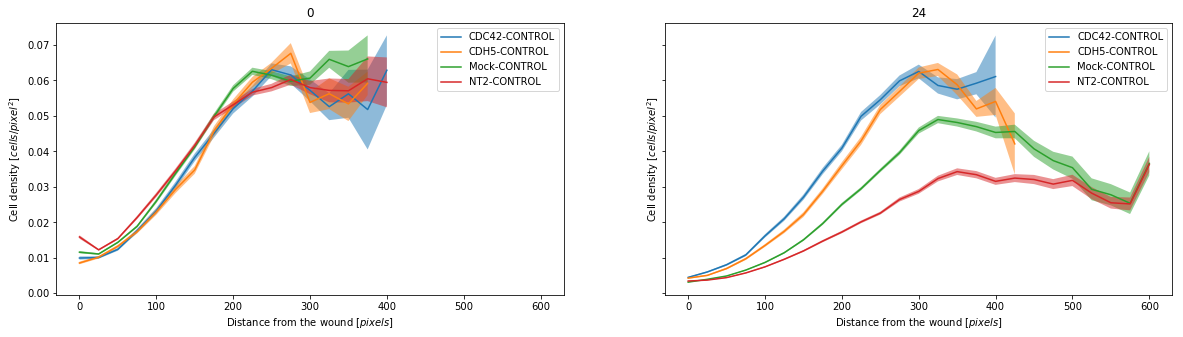

In [2]:
fig, axs = plt.subplots(1, 2,sharex = True, sharey = True, figsize = (20, 5))
for ax, (exp_time, exp_dat) in zip(axs, data_ctr.groupby('time_point')):

    for treatment, res in exp_dat.groupby('condition'):
        dists = cell_densities_from_wound[res.index]

        n_valid = np.sum(~np.isnan(dists), axis=0)
        yy = np.nanmean(dists, axis=0)
        yy[n_valid<3] = np.nan 
        
        err = np.nanstd(dists, axis=0)/np.sqrt(n_valid)
        
        ax.plot(dist_from_wound, yy, label = treatment)
        ax.fill_between(dist_from_wound, yy - err, yy + err, alpha=0.5)
        
    ax.legend()
    ax.set_title(exp_time)
    ax.set_xlabel('Distance from the wound [$pixels$]')
    ax.set_ylabel('Cell density [$cells/pixel^{2}$]')

/Users/avelinojaver/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice
  # Remove the CWD from sys.path while we load stuff.


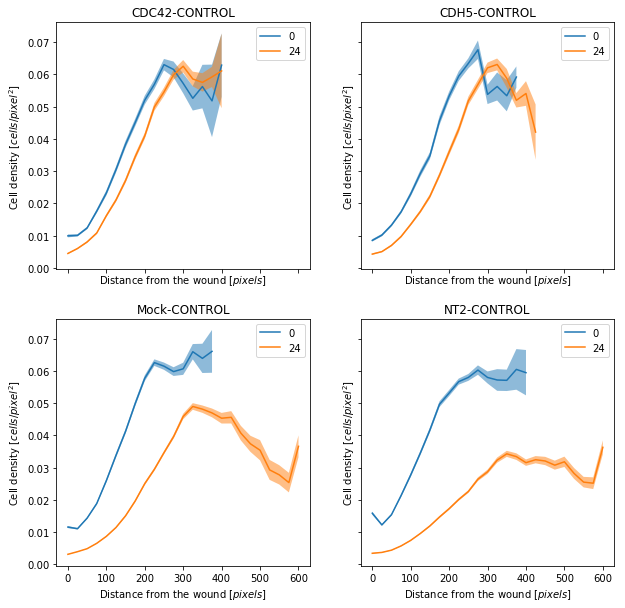

In [3]:
fig, axs = plt.subplots(2, 2,sharex = True, sharey = True, figsize = (10, 10))
axs = axs.flatten()
for ax, (treatment, exp_dat) in zip(axs, data_ctr.groupby('condition')):

    
    for exp_time, res in exp_dat.groupby('time_point'):
        dists = cell_densities_from_wound[res.index]

        n_valid = np.sum(~np.isnan(dists), axis=0)
        yy = np.nanmean(dists, axis=0)
        yy[n_valid<3] = np.nan 
        
        err = np.nanstd(dists, axis=0)/np.sqrt(n_valid)
        
        ax.plot(dist_from_wound, yy, label = exp_time)
        ax.fill_between(dist_from_wound, yy - err, yy + err, alpha=0.5)
        
    ax.legend()
    ax.set_title(treatment)
    ax.set_xlabel('Distance from the wound [$pixels$]')
    ax.set_ylabel('Cell density [$cells/pixel^{2}$]')

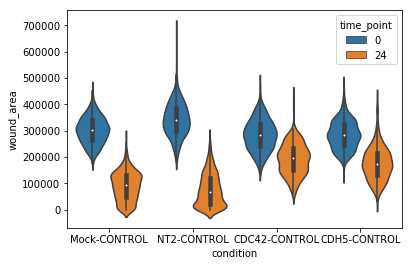

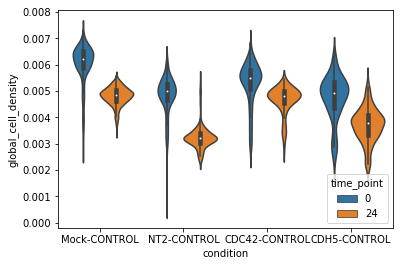

In [4]:
#order = [ 'CDC42', 'CDH5', 'control_mock', 'control_none']
order = [ 'Mock-CONTROL', 'NT2-CONTROL', 'CDC42-CONTROL', 'CDH5-CONTROL']

plt.figure()
sns.violinplot(x="condition", y="wound_area", hue="time_point", data = data_ctr, order = order)

plt.figure()
sns.violinplot(x="condition", y="global_cell_density", hue="time_point", data = data_ctr, order = order)


(6112, 12)
(5376, 12)


100%|██████████| 3056/3056 [00:08<00:00, 364.08it/s]


(3056, 9)


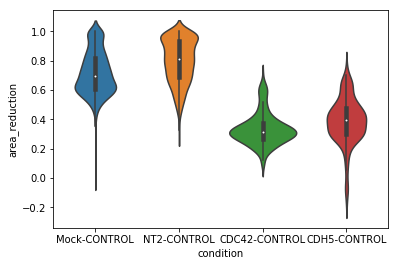

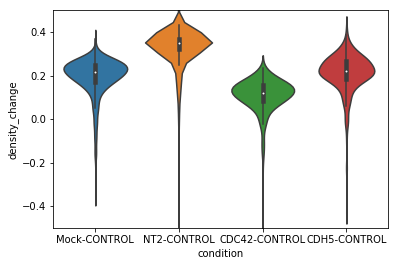

In [17]:
area_changes = []
density_changes = []

densities = []

print(data_info.shape)
print(data_ctr.shape)

for key, dat in tqdm.tqdm(data_info.groupby(['plate_id', 'well_id'])):
    assert len(dat)  <= 2
    if len(dat) == 2:
        dd = dat.sort_values(by = 'time_point').copy()
        
        before_row = dd.iloc[0]
        after_row = dd.iloc[1]
        assert before_row['time_point'] == 0
        assert after_row['time_point'] == 24
        
        row = (*before_row[['plate_id', 'well_id', 'condition']], 
               before_row['wound_area'], 
               after_row['wound_area'], 
               (before_row['wound_area'] - after_row['wound_area'])/before_row['wound_area'],
               before_row['global_cell_density'], 
               after_row['global_cell_density'], 
               ( before_row['global_cell_density'] - after_row['global_cell_density'])/before_row['global_cell_density'],
              ) 
        area_changes.append(row)
        
        #density_changes.append(densities[1]/densities[0])
        densities.append(cell_densities_from_wound[dd.index])
        
        
area_changes = pd.DataFrame(area_changes, columns = ['plate_id', 
                                                     'well_id',
                                                     'condition', 
                                                     'area_t0', 
                                                     'area_t24', 
                                                     'area_reduction',
                                                     'cell_density_t0',
                                                     'cell_density_t24',
                                                     'density_change',
                                                     ])

densities = np.array(densities)



area_changes_ctr = area_changes[area_changes['condition'].str.contains('CONTROL')]


plt.figure()
sns.violinplot(x="condition", y="area_reduction", data = area_changes_ctr, order = order)
#sns.swarmplot(x="condition", y="area_reduction", color = 'k', data = area_changes, order = order)


plt.figure()
sns.violinplot(x="condition", y="density_change", data = area_changes_ctr, order = order)
#sns.swarmplot(x="condition", y="density_change", color = 'k', data = area_changes, order = order)
plt.ylim(-0.5, 0.5)

print(area_changes.shape)


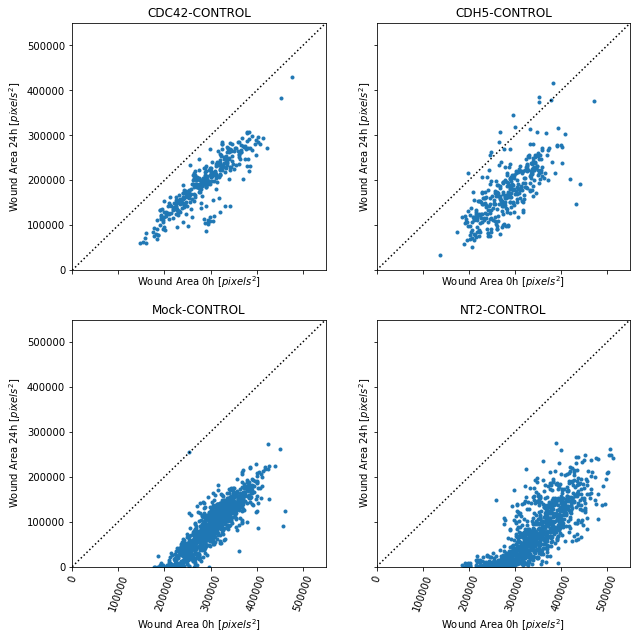

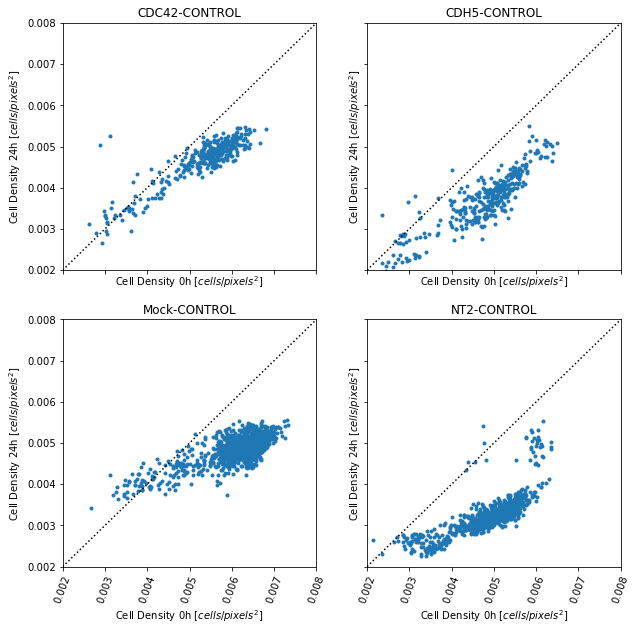

In [6]:
fig, axs = plt.subplots(2, 2, sharex = True, sharey = True, figsize = (10, 10))
axs = axs.flatten()
lims = [0, 55e4]
for ax, (treatment, info) in zip(axs, area_changes_ctr.groupby(['condition'])):
    ax.plot(info['area_t0'], info['area_t24'], '.')
    
    ax.set_title(treatment)
    ax.set_xlabel('Wound Area 0h [$pixels ^2$]')
    ax.set_ylabel('Wound Area 24h [$pixels ^2$]')
    plt.setp( ax.xaxis.get_majorticklabels(), rotation=70 )
    
    ax.plot(lims, lims, ':k')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    
lims = [2e-3, 8e-3]
fig, axs = plt.subplots(2, 2, sharex = True, sharey = True, figsize = (10, 10))
axs = axs.flatten()
for ax, (treatment, info) in zip(axs, area_changes_ctr.groupby(['condition'])):
    ax.plot(info['cell_density_t0'], info['cell_density_t24'], '.')
    
    ax.set_title(treatment)
    ax.set_xlabel('Cell Density 0h [$cells/pixels ^2$]')
    ax.set_ylabel('Cell Density 24h [$cells/pixels ^2$]')
    plt.setp( ax.xaxis.get_majorticklabels(), rotation=70 )
    
    ax.plot(lims, lims, ':k')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    

/Users/avelinojaver/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice
  
/Users/avelinojaver/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: Mean of empty slice


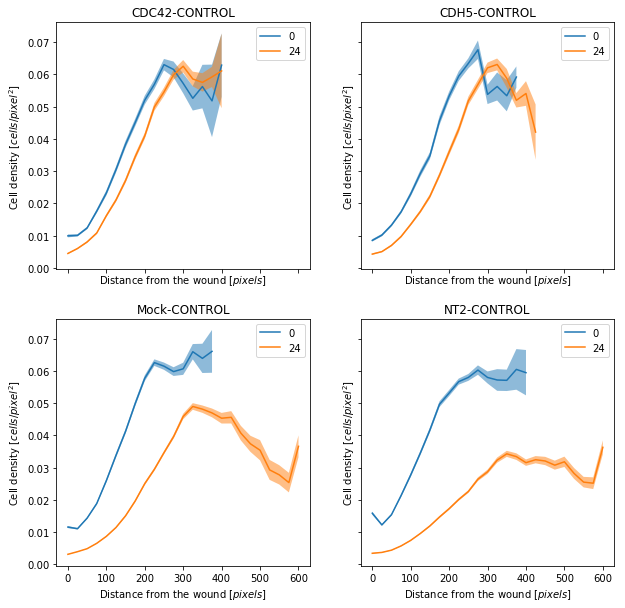

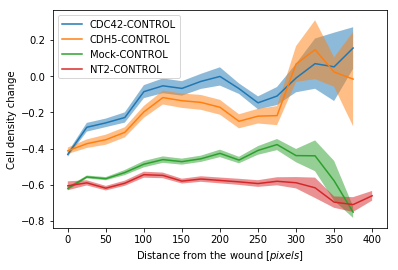

In [18]:
fig, axs = plt.subplots(2, 2, sharex = True, sharey = True, figsize = (10, 10))
axs = axs.flatten()
for ax, (treatment, info) in zip(axs, area_changes_ctr.groupby(['condition'])):
    dat = densities[info.index]
    for ii, exp_time in enumerate([0, 24]):
        dists = dat[:, ii]
        n_valid = np.sum(~np.isnan(dists), axis=0)
        yy = np.nanmean(dists, axis=0)
        yy[n_valid<3] = np.nan 

        err = np.nanstd(dists, axis=0)/np.sqrt(n_valid)

        ax.plot(dist_from_wound, yy, label = exp_time)
        ax.fill_between(dist_from_wound, yy - err, yy + err, alpha=0.5)

    ax.legend()
    ax.set_title(treatment)
    ax.set_xlabel('Distance from the wound [$pixels$]')
    ax.set_ylabel('Cell density [$cells/pixel^{2}$]')



fig, ax = plt.subplots(1, 1)
for (treatment, info) in area_changes_ctr.groupby(['condition']):
    dat = densities[info.index]
    dists = (dat[:, 1] - dat[:, 0] )/dat[:, 0]
    
    
    n_valid = np.sum(~np.isnan(dists), axis=0)
    yy = np.nanmean(dists, axis=0)
    yy[n_valid<3] = np.nan 

    err = np.nanstd(dists, axis=0)/np.sqrt(n_valid)

    ax.plot(dist_from_wound, yy, label = treatment)
    ax.fill_between(dist_from_wound, yy - err, yy + err, alpha=0.5)
    

ax.set_xlabel('Distance from the wound [$pixels$]')
ax.set_ylabel('Cell density change')
ax.legend()


(-0.5, 0.5)

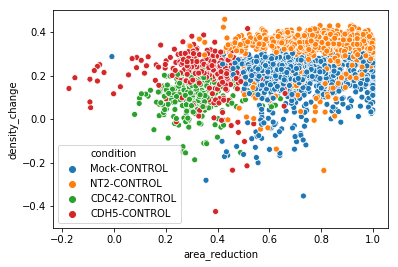

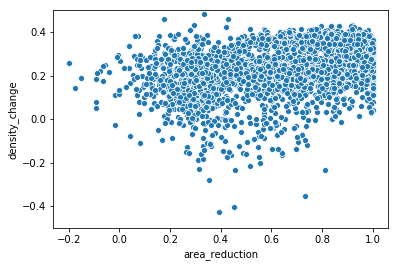

In [19]:
plt.figure()
ax = sns.scatterplot(x="area_reduction", y="density_change", hue="condition", data = area_changes_ctr)
ax.set_ylim((-0.5, 0.5))


area_changes_exp = area_changes[~area_changes['condition'].str.contains('CONTROL')]

plt.figure()
ax = sns.scatterplot(x="area_reduction", y="density_change", data = area_changes)
ax.set_ylim((-0.5, 0.5))


In [23]:
plate_id_exp = area_changes_exp['plate_id'].unique()
for plate_id, plate_ctr in tqdm.tqdm(area_changes_ctr.groupby('plate_id')):
    low_controls = plate_ctr.loc[plate_ctr["condition"] == 'Mock-CONTROL', "area_reduction"]
    hi_controls = plate_ctr.loc[plate_ctr["condition"].isin(('CDC42-CONTROL', 'CDH5-CONTROL')), "area_reduction"]
    
    low_std = np.std(low_controls)
    low_mu = np.mean(low_controls)
    
    hi_std = np.std(hi_controls)
    hi_mu = np.mean(hi_controls)
    
    z_factor = 1 - 3*(hi_std + low_std)/np.abs(hi_mu - low_mu)
    
    print(plate_id, z_factor)
    #print(plate_ctr["condition"].unique())
    
    

 20%|██        | 36/176 [00:00<00:00, 173.97it/s]

001A 0.03511076247878364
001B 0.2197208734408015
002A 0.4843508405882897
002B 0.35924961125829036
003A 0.4758251422777444
004A -0.21324125289514706
004B 0.630803277165966
005A 0.4088370721733563
005B 0.3501892950662022
007A 0.5925374770371133
007B 0.3783175131635774
008A 0.24752452426777038
008B 0.06921891296855875
009A 0.230807586211081
009B 0.16547216853467717
010A 0.2252587906603779
010B -0.06040237552366601
017A 0.23848482423674555
017B -0.003470571783823484
018A 0.15469677447205576
018B 0.037998739967685546
019A -0.01566893825007698
019B 0.38276311760677273
020A 0.056584898742205736
020B 0.336546223514116
021A 0.22311208271260852
021B -0.11142474994408857
022A 0.34168218634792
022B -0.20665031100120612
023A 0.5354973301089098
023B 0.41560166366205276
024A 0.4954848973407978
024B 0.4987793515136969
025A 0.2199640270065607
025B -0.3412488343107505
026A 0.4219459061373182
026B

 26%|██▌       | 46/176 [00:00<00:01, 98.48it/s] 

 0.5907402266493431
027A 0.35191896668082456
027B 0.5136710154788904
028A 0.22646791074608386
028B 0.19903642052251425
029A -0.100324483611822
029B 0.15853935256586027
030A 0.4547041722410693
030B 0.1357034326485056
031A -0.2254495753438437
031B -0.07777908779358422
032A 0.26173973482898594
032B -0.17427131625032133
033A

 39%|███▉      | 69/176 [00:00<00:01, 95.65it/s] 

 0.17627316463108278
033B 0.36979097769434366
034B 0.2110824947560357
035A -12.487451500241102
035B 0.13398406848894595
036B -0.7261072259752979
037A -0.27435479292972076
037B -0.5127928675180573
038A 0.1595352423906421
039A -0.1430644635978826
039B 0.3316644139264815
040A -0.03972364641402781
040B 0.24095018962825843
041A -1.496179080930951
041B -1.3693138357544226
042A -0.5980907691890207
042B -1.0325604441810987
043A -0.23250387771139014
043B 0.2362722915365395
044A -0.1879790431842625
044B -0.20394977482576482
045A 0.6771611966370116
045B

 58%|█████▊    | 102/176 [00:00<00:00, 121.53it/s]

 0.16381422875086205
046A -0.6395844797751504
046B 0.2696448440257093
047A -0.23603220193809316
047B -0.3580524913784604
048A -0.6880605292246111
048B -1.8283677137617573
049A -0.15349871067661258
049B -1.061939831371455
050A -0.9708560744605566
050B -1.6257380557138332
051A -0.10487834661214235
051B -0.7492886906077638
052A 0.13296528728408408
052B -0.7800246385579823
053A -0.4027632890734325
053B -2.0807482500299637
054A -0.6692621825758587
054B -1.2555388128239247
055A -0.3489605594325531
055B -1.1696542002854446
056A -0.7544710038075801
057A -0.5674328148348877
058A -0.2589878851175067
058B -0.49707868507798825
065A -0.5957239706008473
065B -2.078610500270342
066A -1.2527535220812025
066B -1.1395128798940406
067A -1.1001594672845894
067B -0.9924279019433322
068A 0.03332630728709185
068B -0.6262951624344932
069A

 76%|███████▌  | 133/176 [00:01<00:00, 136.03it/s]

 -0.09944270331243987
069B 0.03352449097459054
070A -0.5825090194432327
070B -2.1814549748498075
071A 0.023440311305049644
071B 0.2355816416366131
072B 0.03576096374601889
073A -0.37658739972926103
073B 0.32289805439065555
074A -0.19526772123092884
074B -1.04488777212825
075A 0.12245179673834539
075B -0.2973990255768779
076A 0.2720397797355414
076B -0.5219247683851709
077A -1.187951028224191
077B -0.9597561779194612
078A -0.2698820567017419
078B -1.0195601620152313
079A -2.744622445446711
079B -2.389892682984915
080A -1.512122912295204
080B -2.125086169736471
081A -1.6205123172000762
081B -2.9296473526968962
082A -5.173129621034047
082B -1.3500226779352902
083A 0.5046285292427712
083B 0.2774870372189726
084A 0.6244784773284038
084B 0.0803728753991152
085A 0.6615887963675273


 93%|█████████▎| 163/176 [00:01<00:00, 139.47it/s]

085B 0.17058201441827125
086A 0.5494447707296538
086B 0.30739174333323827
087A 0.5014656143443903
087B 0.22625934871475506
088A 0.24479730643142306
088B -0.1480795206783172
089A -0.7679058051410488
089B -0.7924522539958385
090A 0.17999550760592908
090B -0.1987498200768565
091A 0.48719727549024205
091B 0.2769413390935658
092A 0.2739492517613924
092B 0.3221932025235541
093A 0.22822756839056335
093B 0.3514600628290623
094A 0.1781813783981765
094B 0.3941148615928175
095A 0.12921288580778234
095B 0.02135190858248237
096A -0.11472368706203029
097A 0.02093494420255948
098A -0.12626001335836934
098B -0.3085698681649802
099A -1.5577798165186736
099B -2.313081944016466
100B -2.267411920403686
101A -1.1876329777954888
101B -1.2040972319613186


100%|██████████| 176/176 [00:01<00:00, 130.68it/s]

102A -0.4090375232983927
102B -0.6712671236492034
103A 0.6130767610743767
103B 0.04708821963065457
104A 0.03374857988432867
104B -0.16685383539390108
105A 0.24353201849439887
105B 0.22293246374621667
106A 0.31708142993113775
106B -0.16325448958125044


  1%|          | 2/176 [00:00<00:10, 16.21it/s]

{'004B', '104A', '038A', '065B', '029B', '106A', '082B', '024A', '026B', '055A', '047A', '081A', '028A', '066B', '094A', '106B', '026A', '053A', '105B', '004A', '105A', '104B', '087B', '094B', '089B', '101B', '089A', '028B', '087A', '098A', '101A', '055B', '098B', '081B', '100B', '053B', '082A', '029A', '047B', '024B', '072B', '065A'}


100%|██████████| 176/176 [00:13<00:00, 12.74it/s]


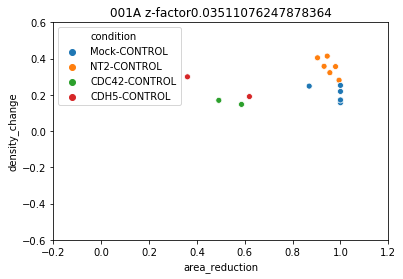

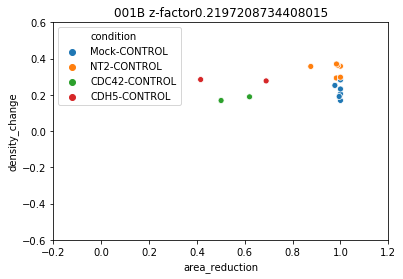

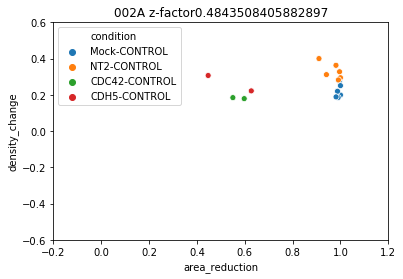

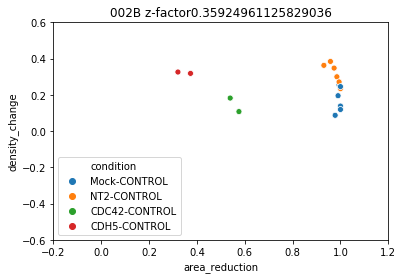

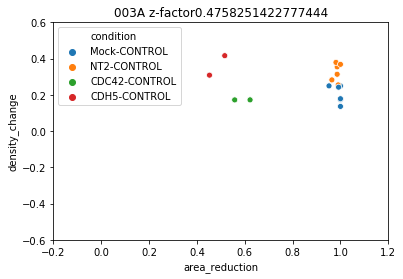

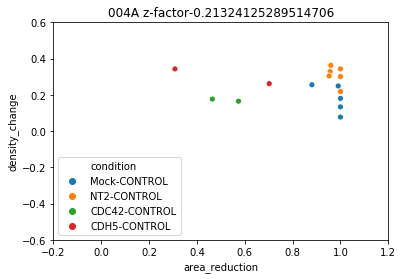

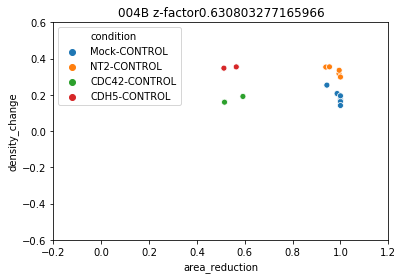

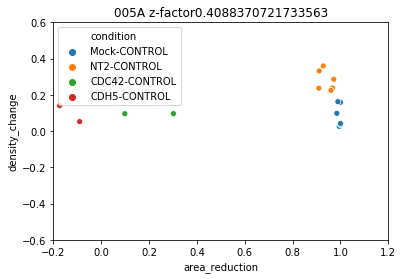

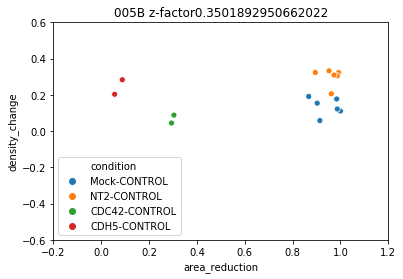

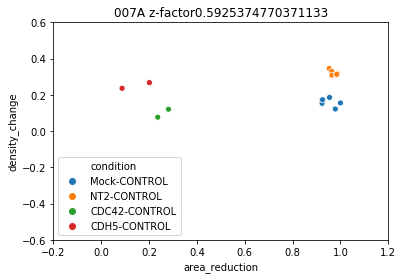

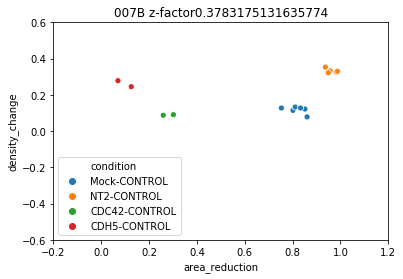

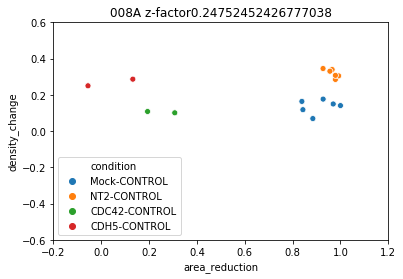

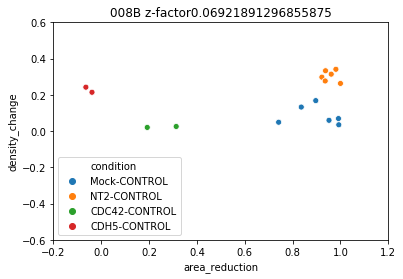

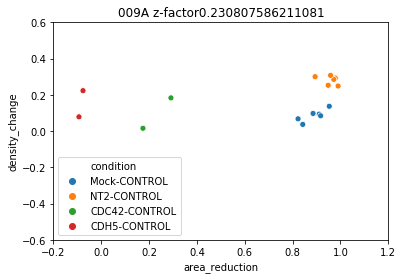

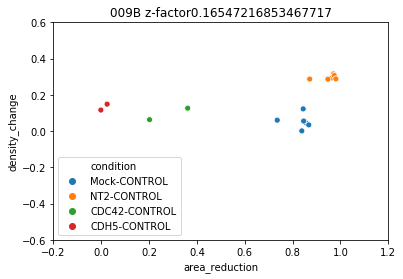

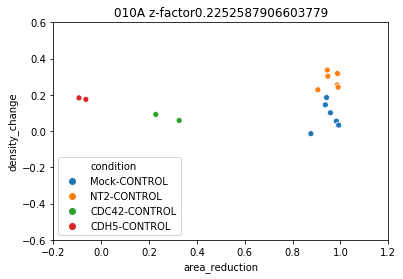

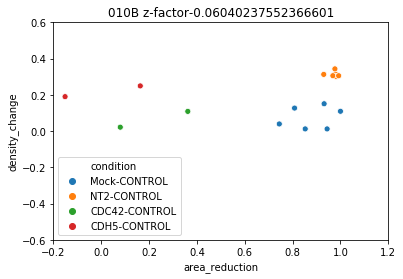

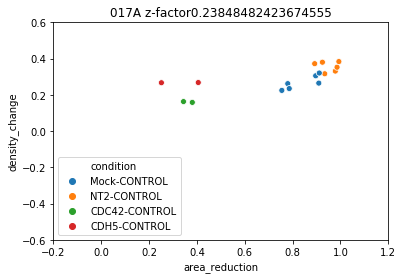

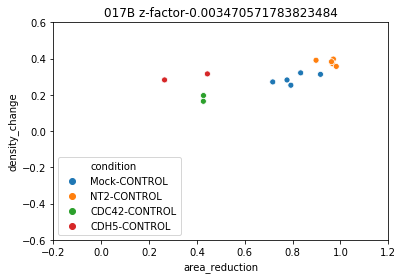

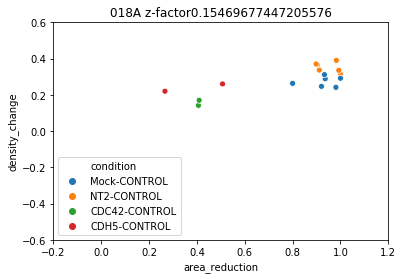

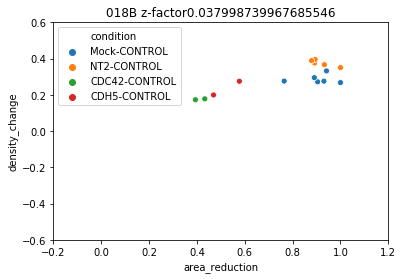

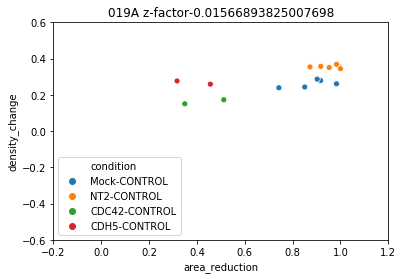

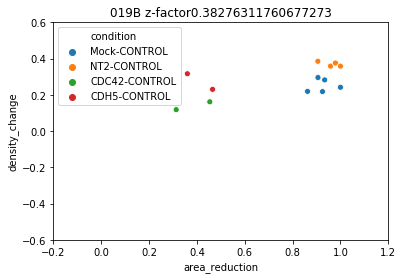

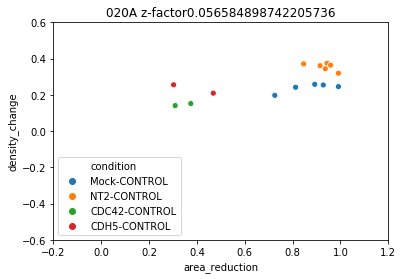

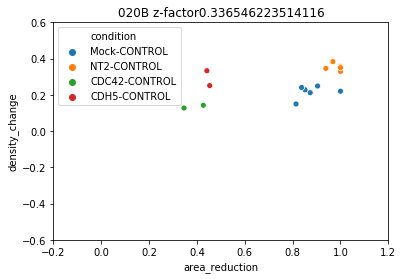

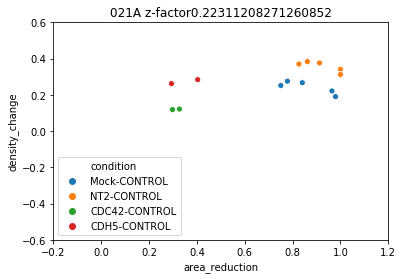

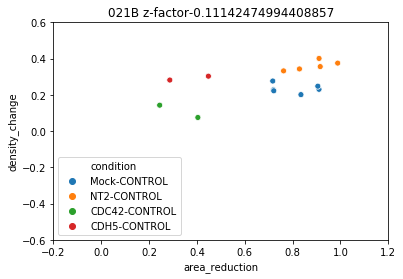

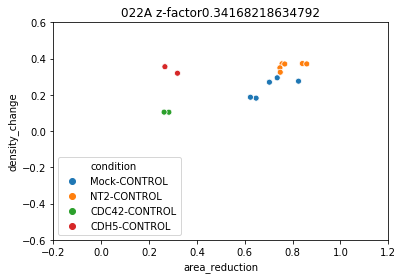

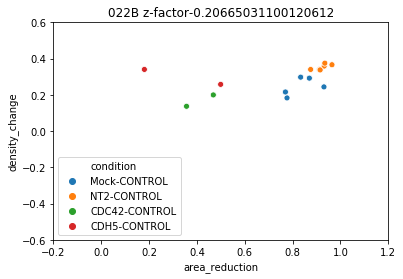

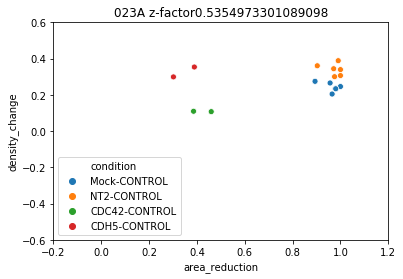

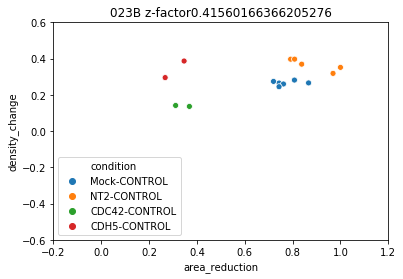

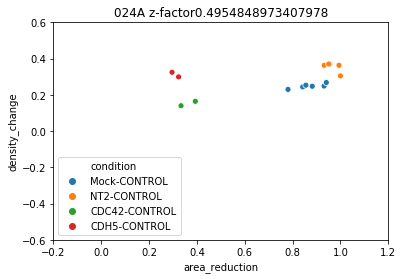

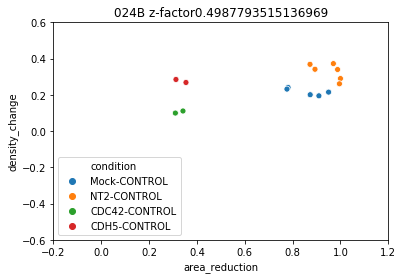

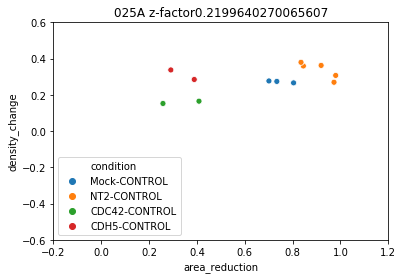

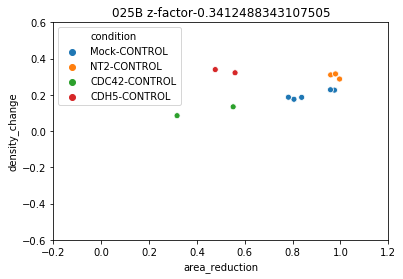

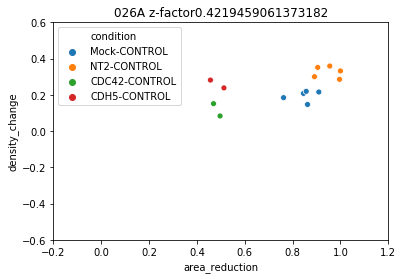

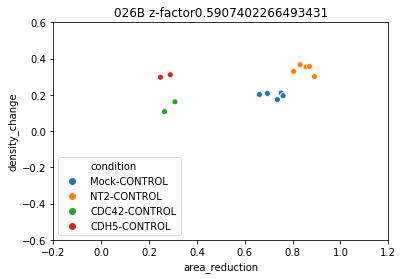

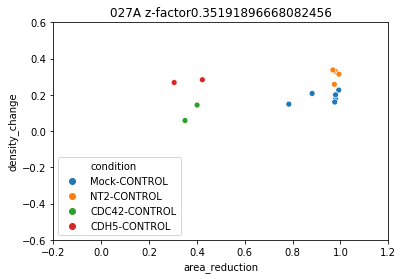

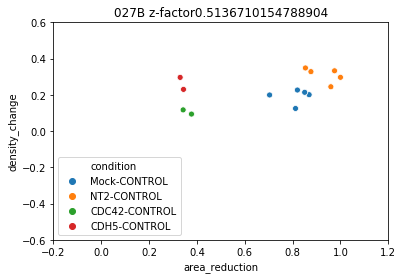

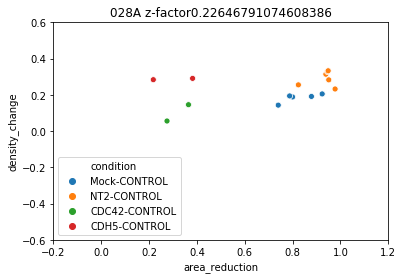

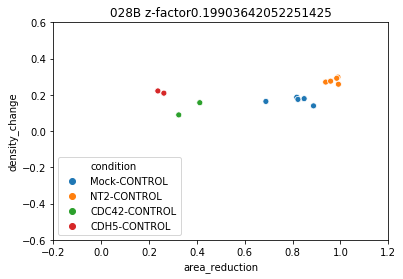

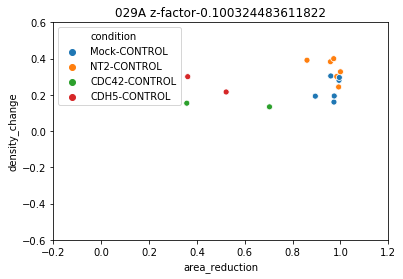

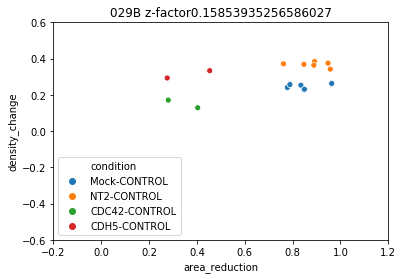

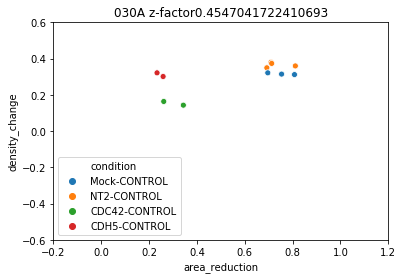

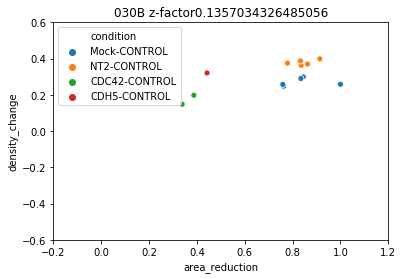

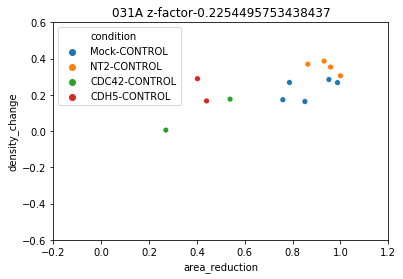

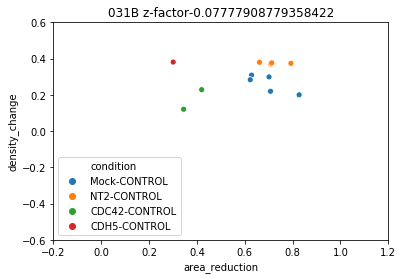

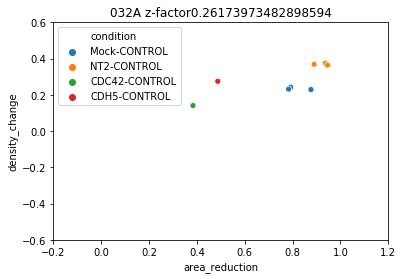

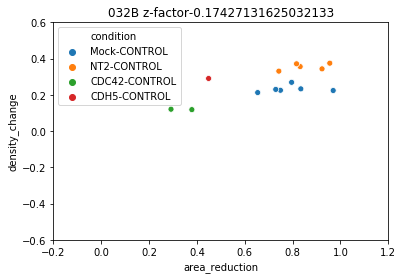

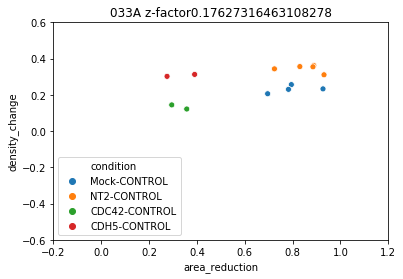

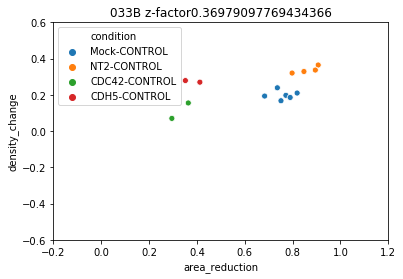

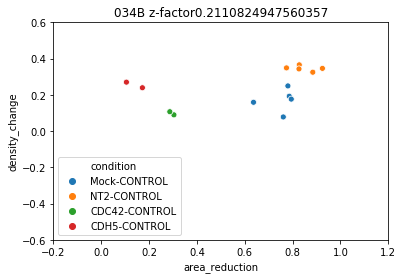

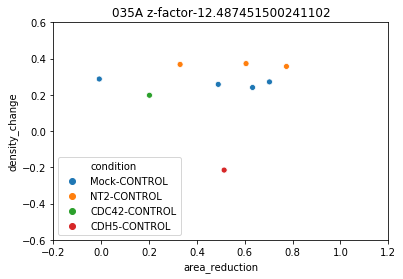

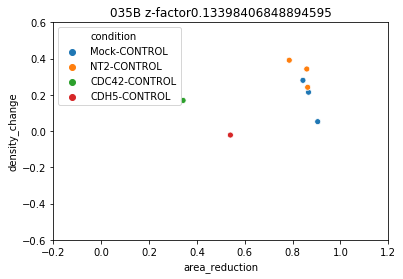

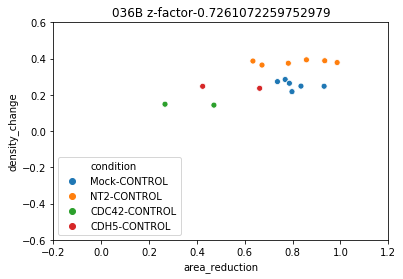

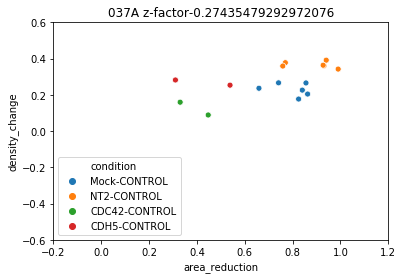

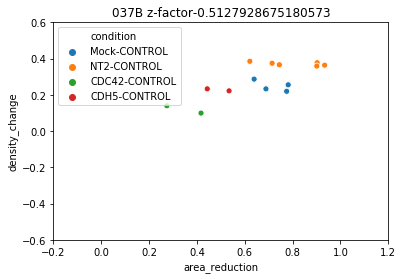

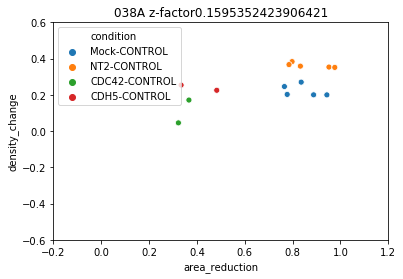

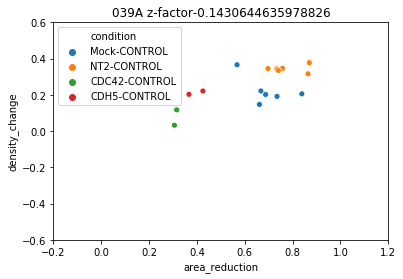

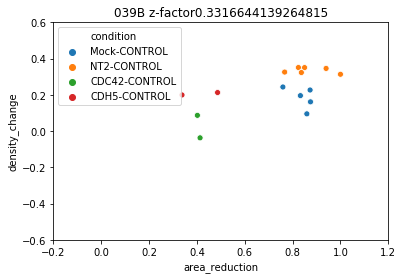

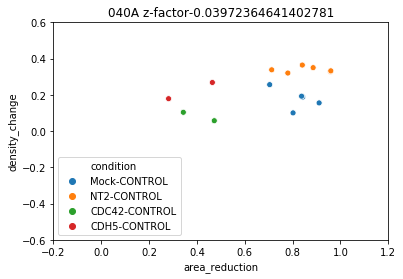

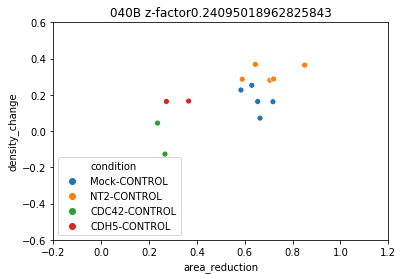

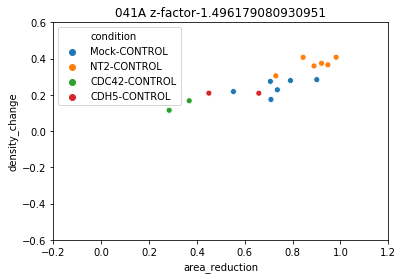

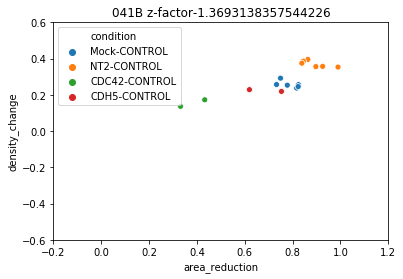

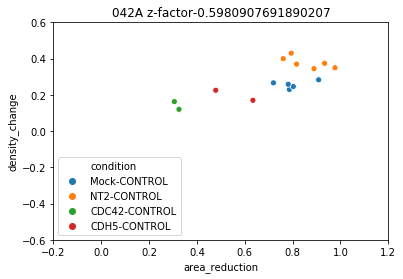

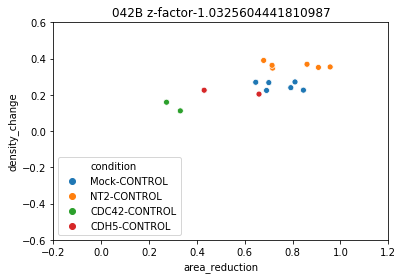

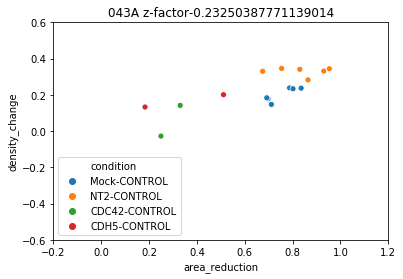

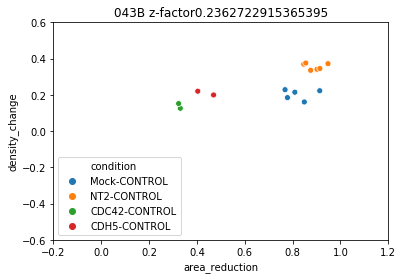

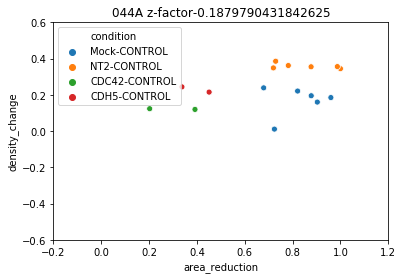

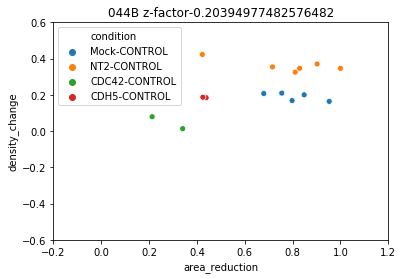

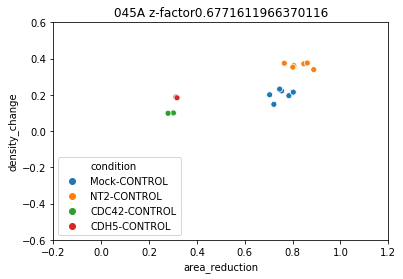

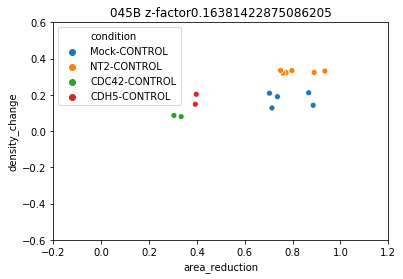

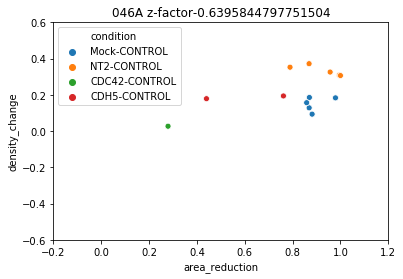

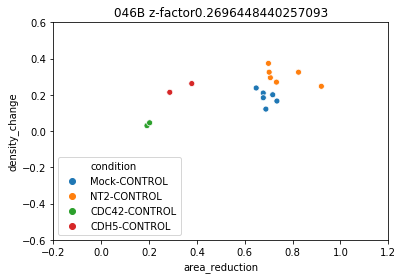

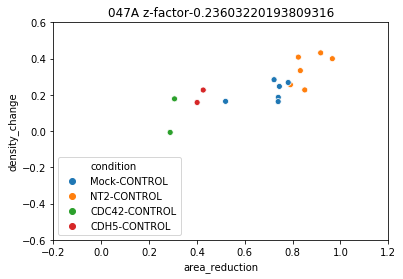

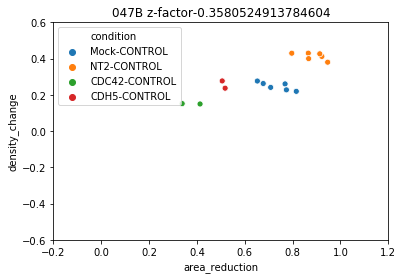

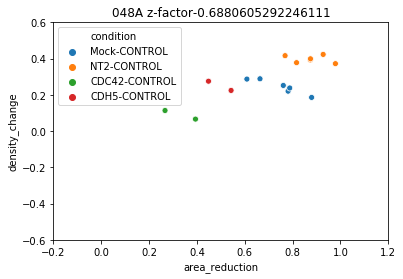

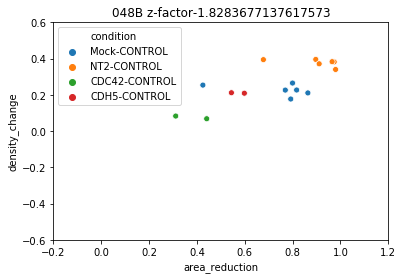

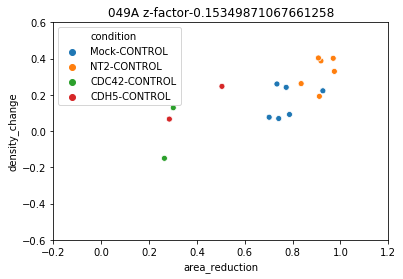

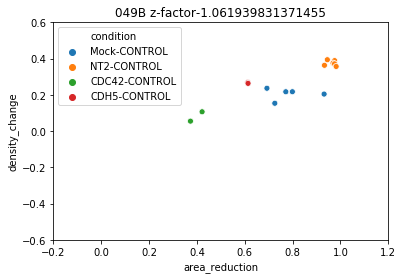

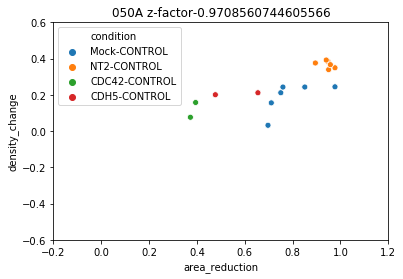

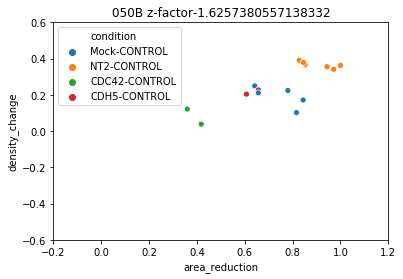

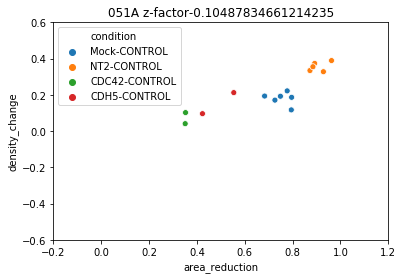

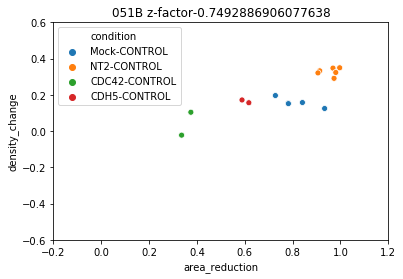

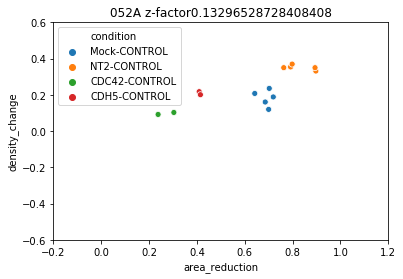

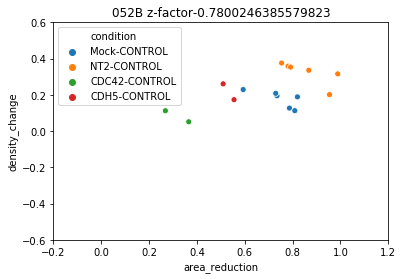

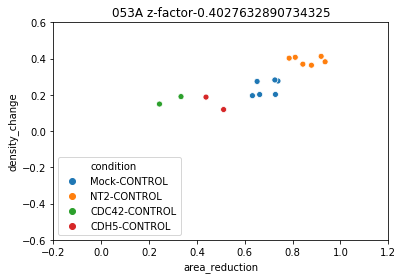

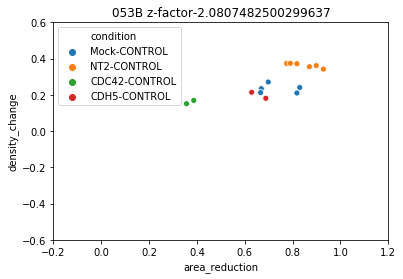

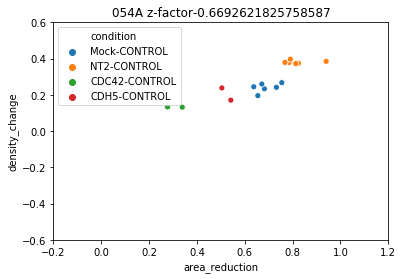

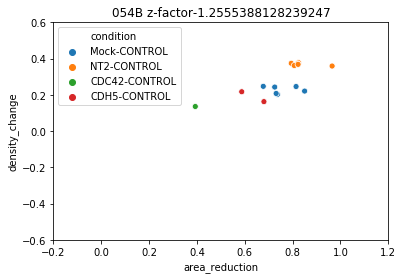

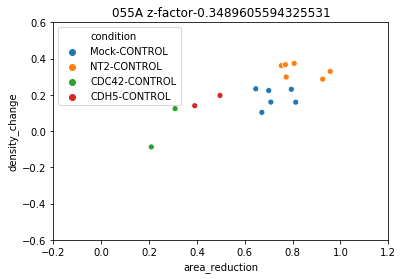

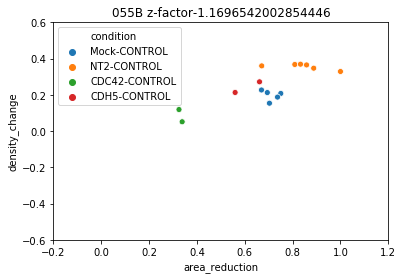

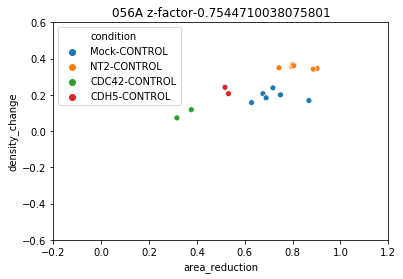

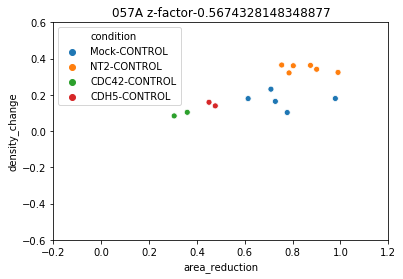

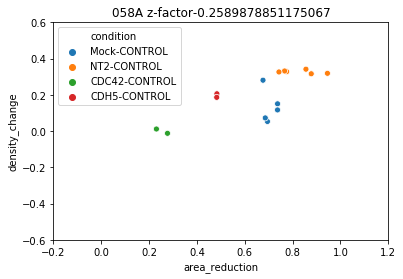

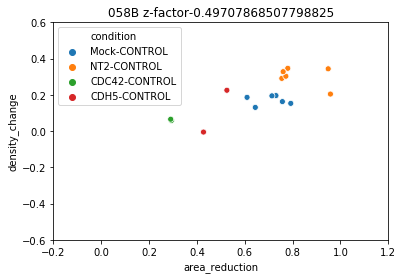

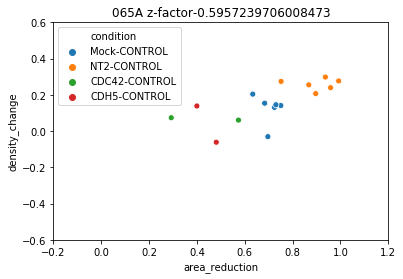

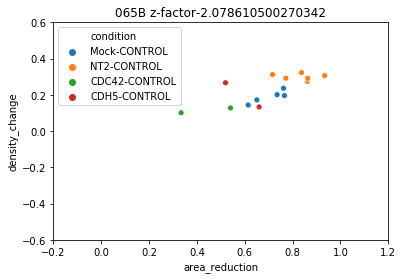

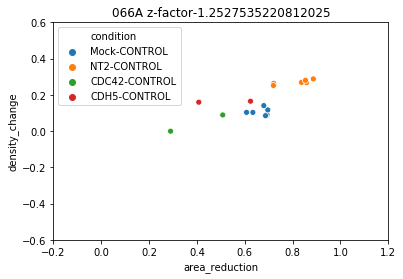

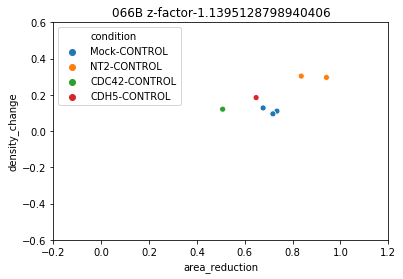

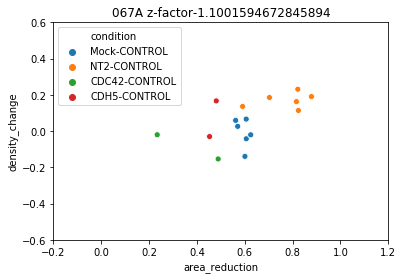

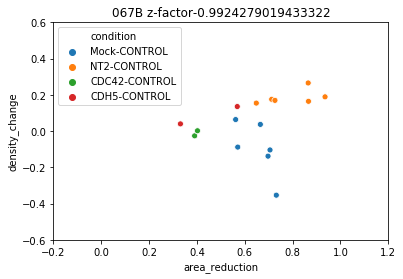

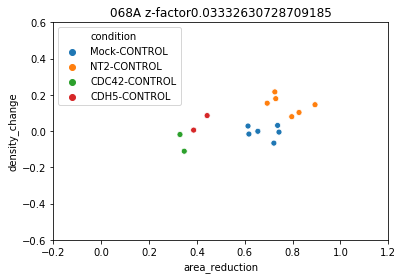

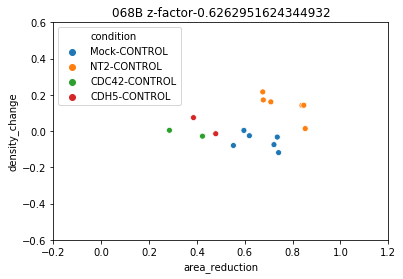

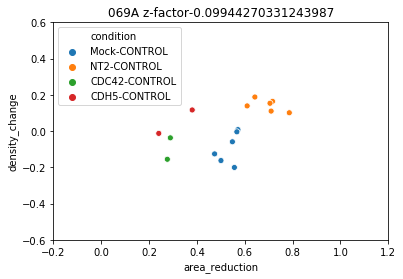

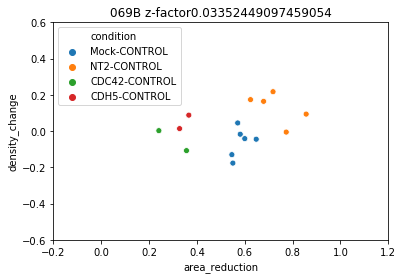

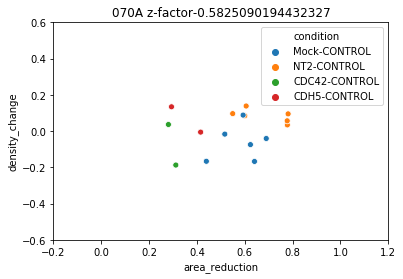

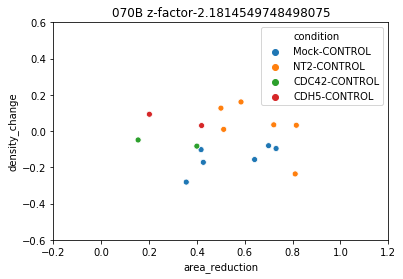

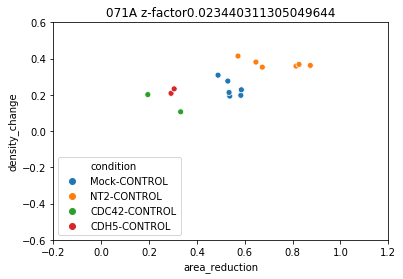

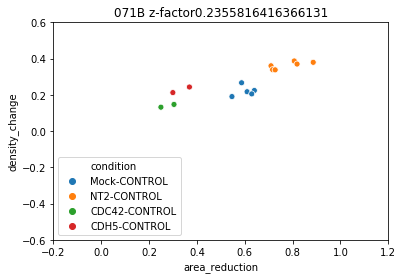

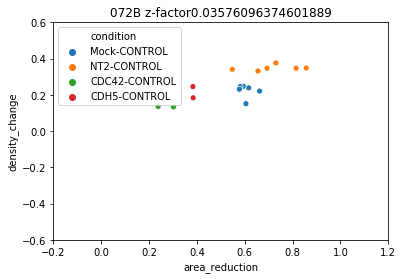

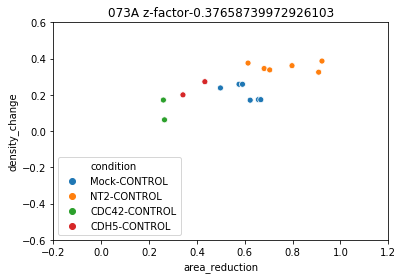

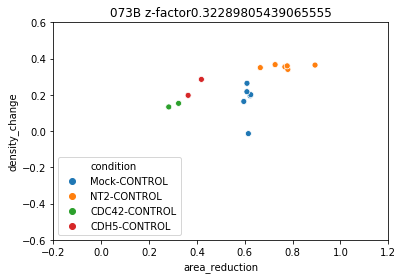

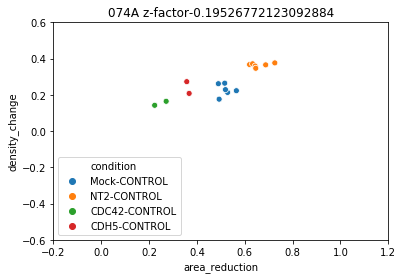

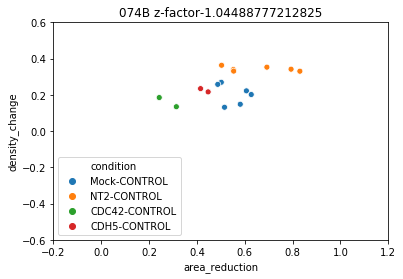

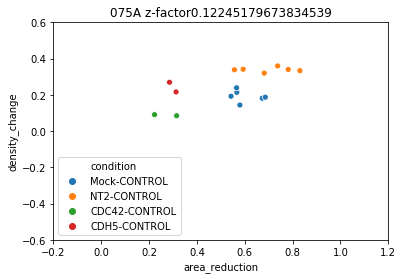

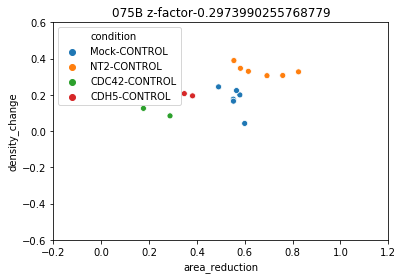

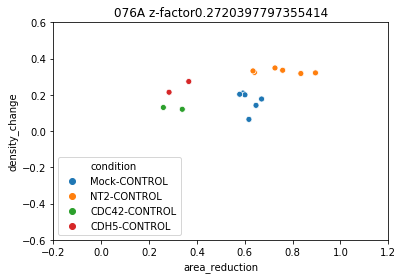

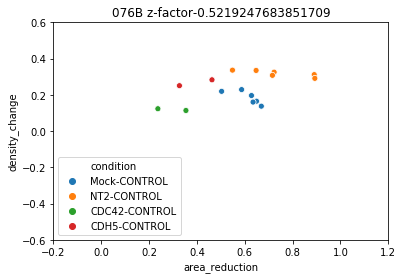

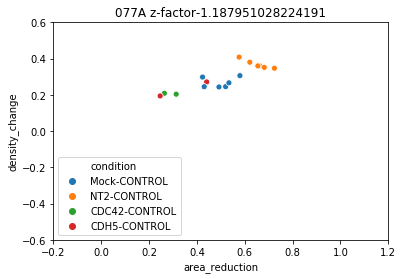

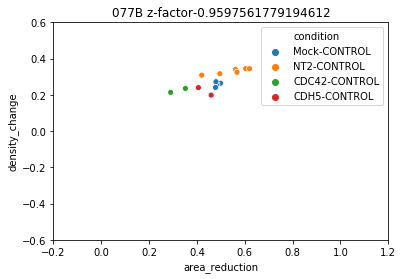

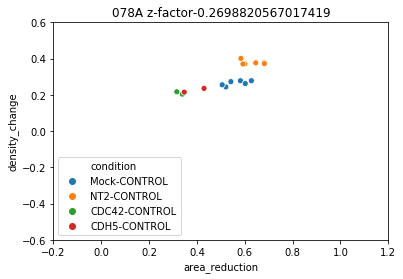

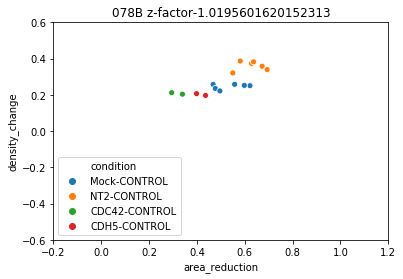

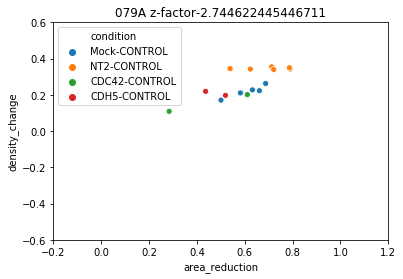

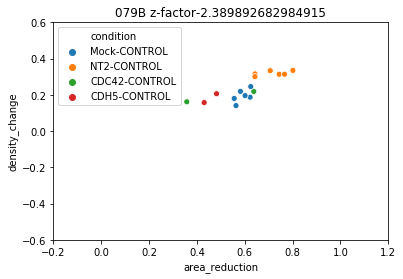

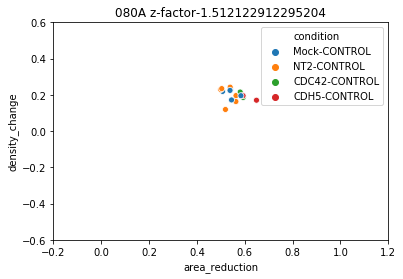

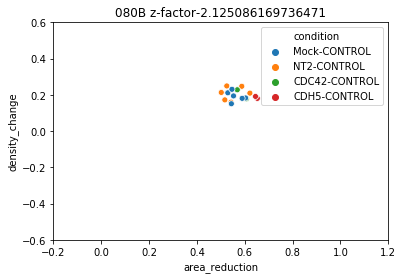

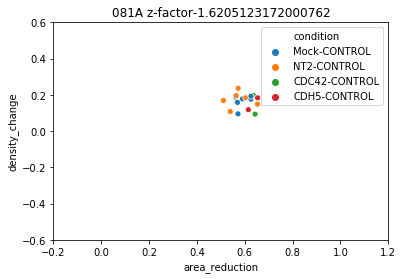

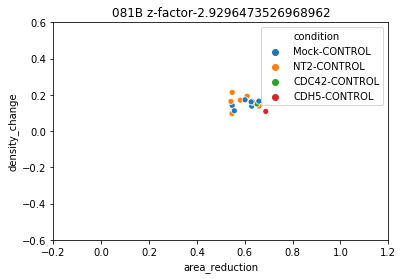

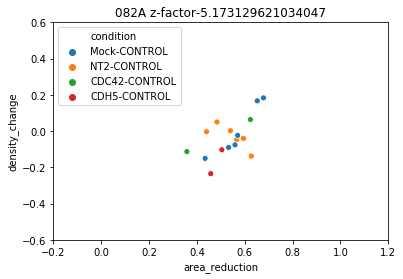

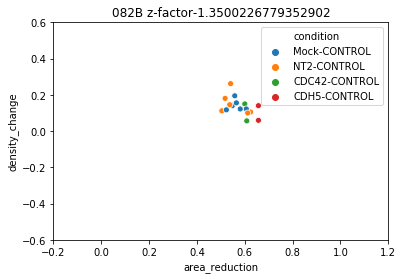

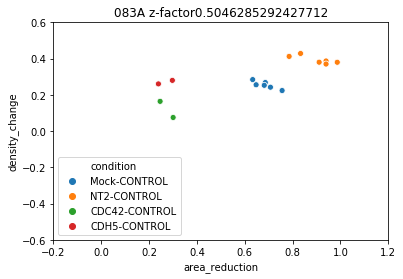

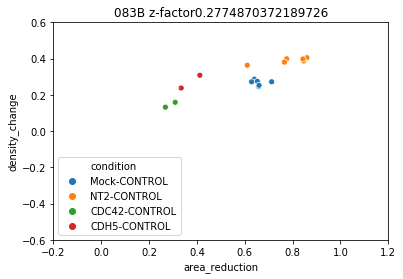

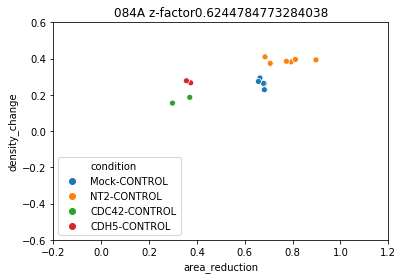

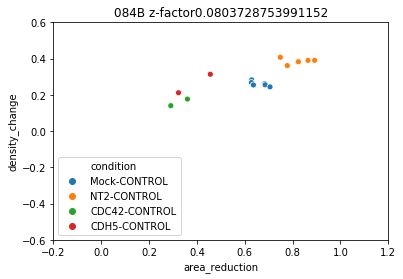

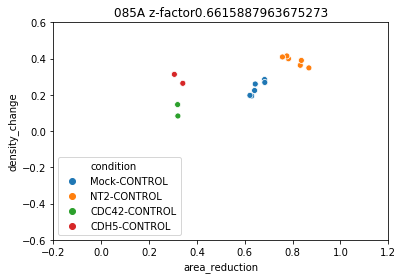

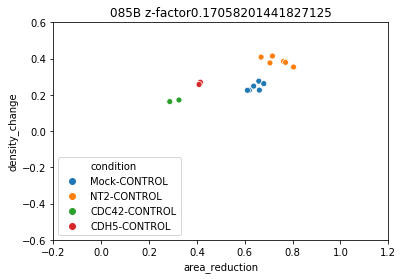

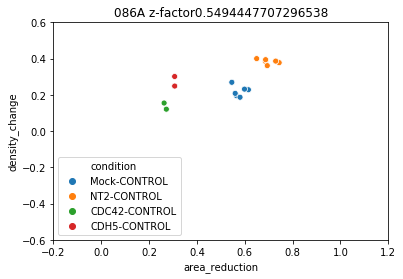

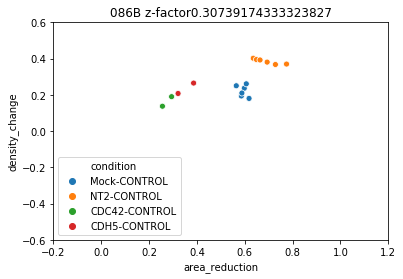

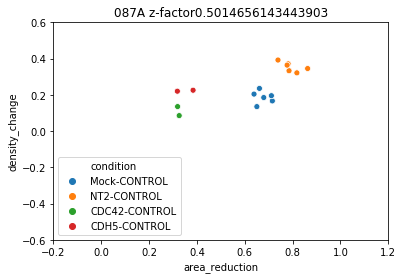

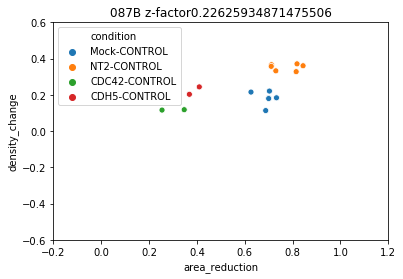

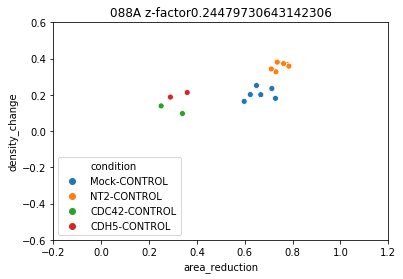

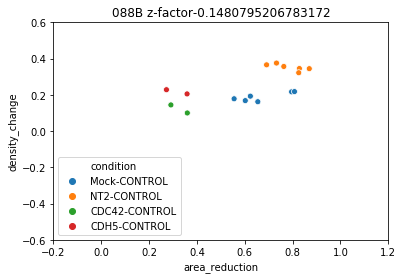

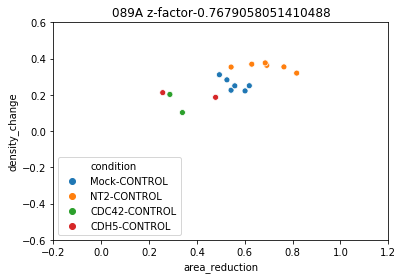

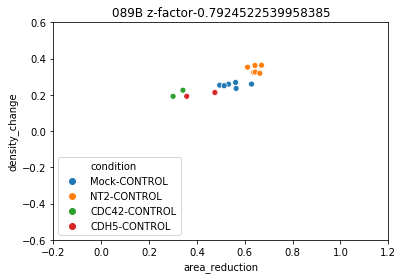

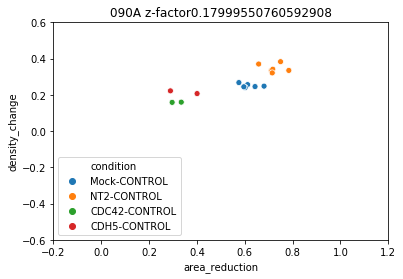

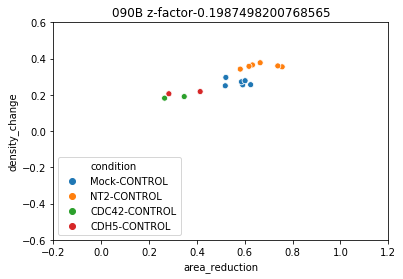

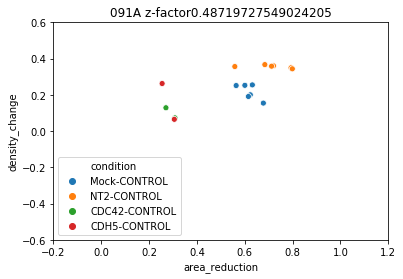

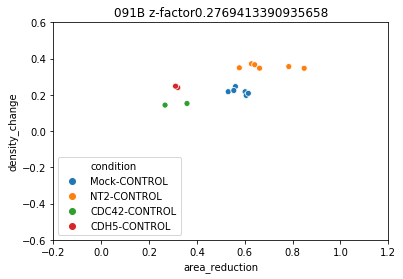

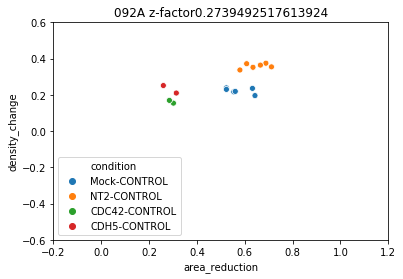

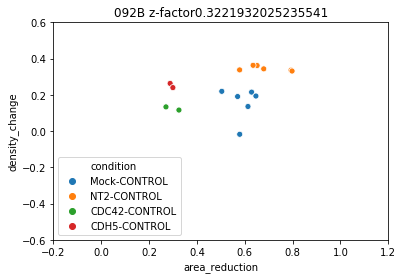

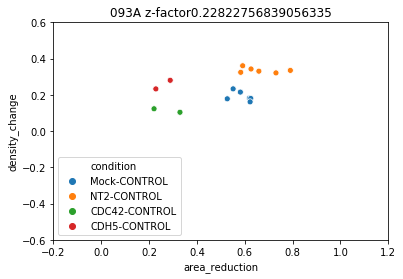

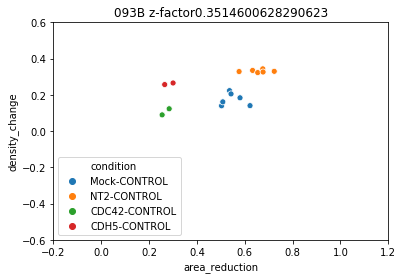

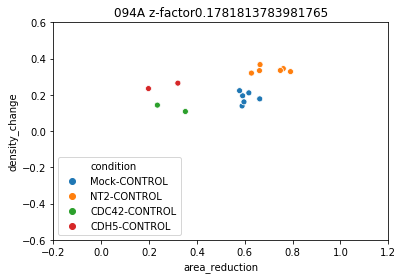

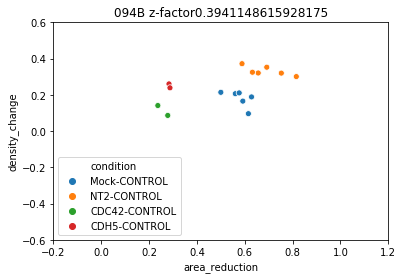

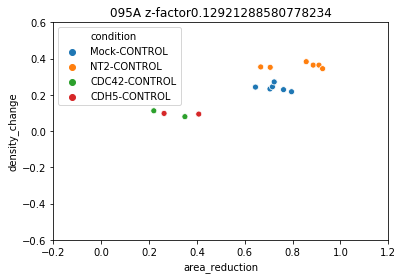

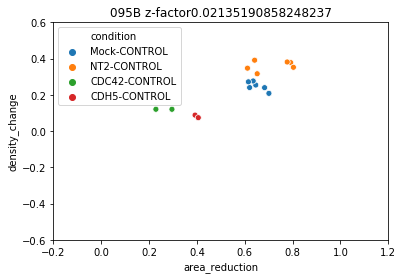

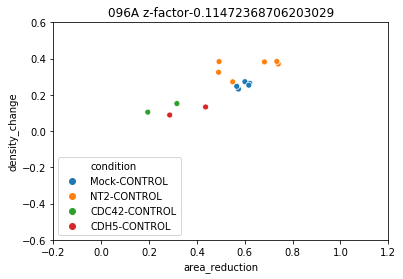

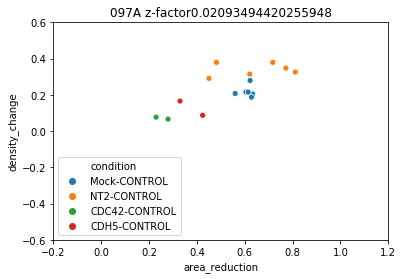

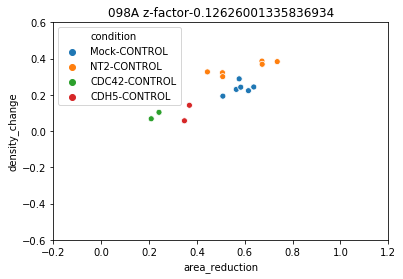

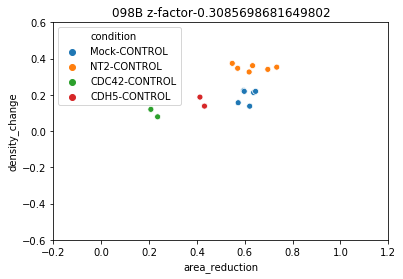

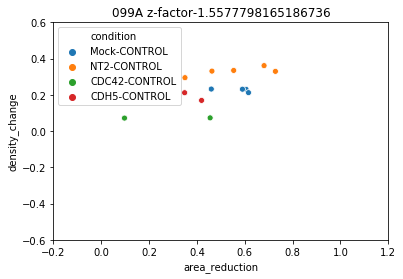

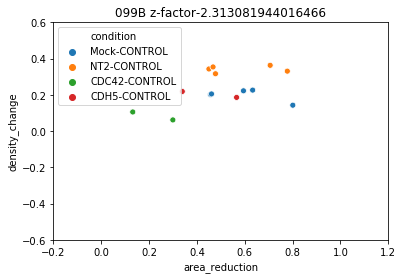

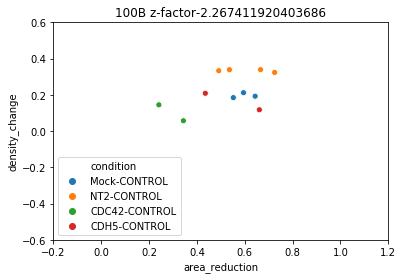

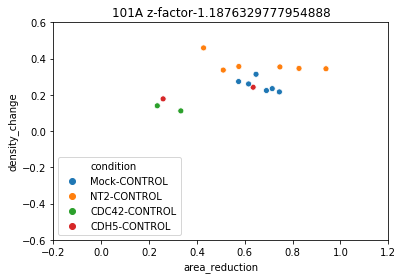

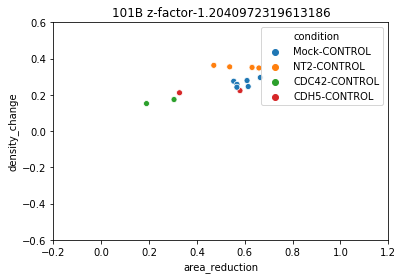

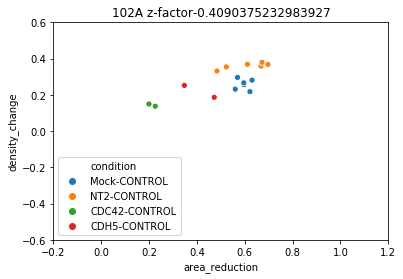

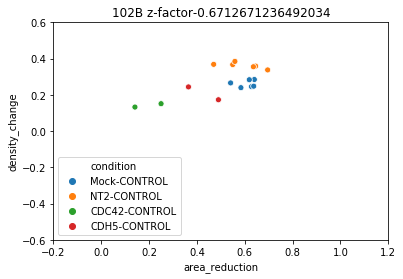

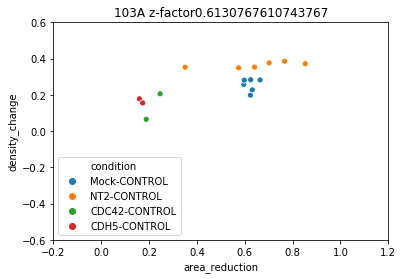

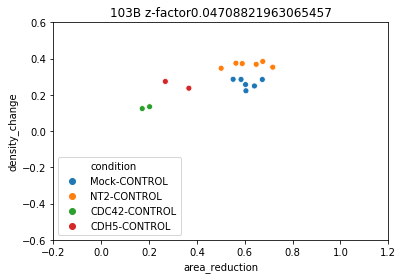

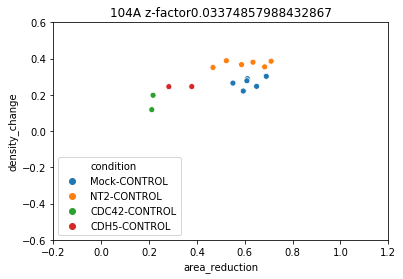

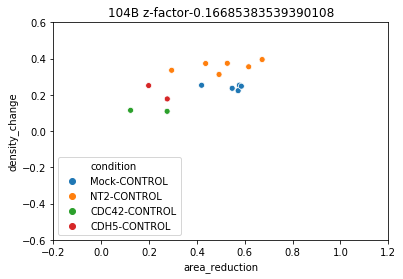

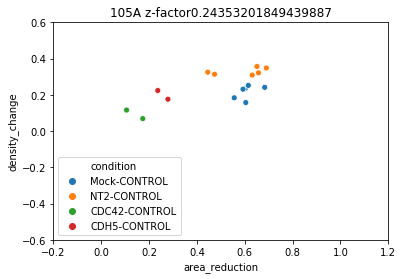

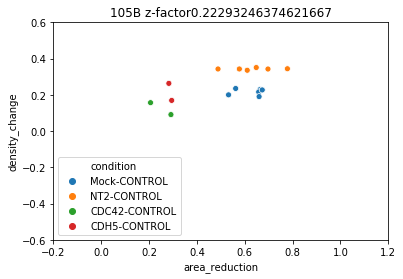

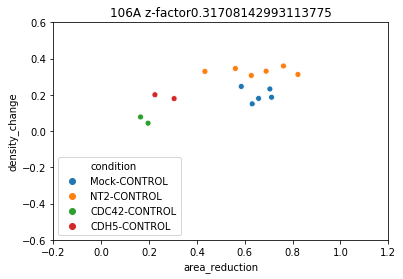

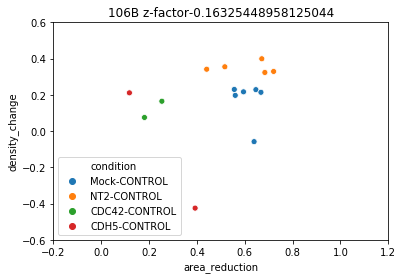

In [27]:
plate_id_exp = area_changes_exp['plate_id'].unique()


plates_without_exp = set(area_changes_ctr['plate_id'].values) - set(area_changes_exp['plate_id'].values) 
print(plates_without_exp)

for plate_id, plate_ctr in tqdm.tqdm(area_changes_ctr.groupby('plate_id')):
    
    low_controls = plate_ctr.loc[plate_ctr["condition"] == 'Mock-CONTROL', "area_reduction"]
    hi_controls = plate_ctr.loc[plate_ctr["condition"].isin(('CDC42-CONTROL', 'CDH5-CONTROL')), "area_reduction"]
    
    low_std = np.std(low_controls)
    low_mu = np.mean(low_controls)
    hi_std = np.std(hi_controls)
    hi_mu = np.mean(hi_controls)
    z_factor = 1 - 3*(hi_std + low_std)/np.abs(hi_mu - low_mu)
    
    
    low_med = np.median(low_controls)
    low_mad = np.median(np.abs(low_controls - low_med))
    
    hi_med = np.median(hi_controls)
    hi_mad = np.median(np.abs(hi_controls - hi_med))
    
    
    beta = 
    
    plt.figure()
    ax = sns.scatterplot(x="area_reduction", y="density_change", hue="condition", data = plate_ctr)
    ax.set_xlim((-0.2, 1.2))
    ax.set_ylim((-0.6, 0.6))
    
    t_str = f'{plate_id} z-factor{z_factor}'
    ax.set_title(t_str)
    
    
    


In [10]:
print(area_changes['plate_id'].unique())
print(area_changes['well_id'].unique())

['001A' '001B' '002A' '002B' '003A' '004A' '004B' '005A' '005B' '007A'
 '007B' '008A' '008B' '009A' '009B' '010A' '010B' '017A' '017B' '018A'
 '018B' '019A' '019B' '020A' '020B' '021A' '021B' '022A' '022B' '023A'
 '023B' '024A' '024B' '025A' '025B' '026A' '026B' '027A' '027B' '028A'
 '028B' '029A' '029B' '030A' '030B' '031A' '031B' '032A' '032B' '033A'
 '033B' '034B' '035A' '035B' '036B' '037A' '037B' '038A' '039A' '039B'
 '040A' '040B' '041A' '041B' '042A' '042B' '043A' '043B' '044A' '044B'
 '045A' '045B' '046A' '046B' '047A' '047B' '048A' '048B' '049A' '049B'
 '050A' '050B' '051A' '051B' '052A' '052B' '053A' '053B' '054A' '054B'
 '055A' '055B' '056A' '057A' '058A' '058B' '065A' '065B' '066A' '066B'
 '067A' '067B' '068A' '068B' '069A' '069B' '070A' '070B' '071A' '071B'
 '072B' '073A' '073B' '074A' '074B' '075A' '075B' '076A' '076B' '077A'
 '077B' '078A' '078B' '079A' '079B' '080A' '080B' '081A' '081B' '082A'
 '082B' '083A' '083B' '084A' '084B' '085A' '085B' '086A' '086B' '087A'
 '087B

In [11]:
area_changes[area_changes['plate_id'] == '080A']

plate_id well_id      condition  area_t0  area_t24  area_reduction  \
2202     080A     A01   Mock-CONTROL   329358    146000       -0.556713   
2203     080A     A04           FGF4   363629    106485       -0.707160   
2204     080A     A12   Mock-CONTROL   391544    192942       -0.507228   
2205     080A     B01    NT2-CONTROL   341750    149279       -0.563192   
2206     080A     B12    NT2-CONTROL   417856    209256       -0.499215   
2207     080A     C01    NT2-CONTROL   329314    143981       -0.562785   
2208     080A     C12    NT2-CONTROL   376015    186623       -0.503682   
2209     080A     D01  CDC42-CONTROL   320357    130338       -0.593148   
2210     080A     D12  CDC42-CONTROL   342290    143481       -0.580820   
2211     080A     E01   CDH5-CONTROL   280696     98569       -0.648841   
2212     080A     E12   CDH5-CONTROL   317331    129215       -0.592807   
2213     080A     F01   Mock-CONTROL   347799    144777       -0.583734   
2214     080A     F03        PGLYRP4   365716    296665       -0.188810   
2215     080A     F12   Mock-CONTROL   392521    180600       -0.539897   
2216     080A     G01    NT2-CONTROL   324562    156090       -0.519075   
2217     080A     G12    NT2-CONTROL   398019    183545       -0.538854   
2218     080A     H01   Mock-CONTROL   343358    156395       -0.544513   
2219     080A     H12   Mock-CONTROL   380344    175621       -0.538257   

      cell_density_t0  cell_density_t24  density_change  
2202         0.006180          0.005133       -0.169359  
2203         0.005910          0.004208       -0.287966  
2204         0.006131          0.004785       -0.219547  
2205         0.006090          0.004893       -0.196466  
2206         0.006359          0.004898       -0.229744  
2207         0.006072          0.005078       -0.163715  
2208         0.006338          0.004849       -0.234946  
2209         0.006178          0.005028       -0.186209  
2210         0.006290          0.004931       -0.216044  
2211         0.006208          0.005147       -0.170925  
2212         0.006042          0.004859       -0.195898  
2213         0.006273          0.005045       -0.195796  
2214         0.005882          0.005882       -0.000066  
2215         0.006193          0.004779       -0.228341  
2216         0.006049          0.005325       -0.119729  
2217         0.006155          0.004660       -0.242900  
2218         0.005951          0.004925       -0.172362  
2219         0.006033          0.004675       -0.225004